In [1]:
# importing libraries
import pandas as pd                                  # data science essentials
import matplotlib.pyplot as plt                      # data visualization
import seaborn as sns                      # enhanced data viz
from sklearn.model_selection import train_test_split # train-test split
from sklearn.linear_model import LogisticRegression  # logistic regression
import statsmodels.formula.api as smf                # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import plot_tree                   # tree plots


# loading data
file = "./__storage/GOT_character_predictions.xlsx"

got = pd.read_excel(io = file)

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)


# displaying the head of the dataset
got.head(n = 5)

,S.No,name,title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive
0,1,Viserys II Targaryen,NaN,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,NaN,0,0,0,0,0,1.0,0.0,0.0,NaN,0,0,NaN,11,0.605351,0
1,2,Walder Frey,Lord of the Crossing,Rivermen,208.0,NaN,NaN,NaN,House Frey,Perra Royce,1,1,1,1,1,NaN,NaN,NaN,1.0,1,1,97.0,1,0.896321,1
2,3,Addison Hill,Ser,NaN,NaN,NaN,NaN,NaN,House Swyft,NaN,0,0,0,1,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0.267559,1
3,4,Aemma Arryn,Queen,NaN,82.0,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,0,0,0,0,0,NaN,NaN,NaN,0.0,1,1,23.0,0,0.183946,0
4,5,Sylva Santagar,Greenstone,Dornish,276.0,NaN,NaN,NaN,House Santagar,Eldon Estermont,0,0,0,1,0,NaN,NaN,NaN,1.0,1,1,29.0,0,0.043478,1


In [2]:
# user-defined functions

#########################
# mv_flagger
#########################
def mv_flagger(df):
    """
Flags all columns that have missing values with 'm-COLUMN_NAME'.

PARAMETERS
----------
df : DataFrame to flag missing values


RETURNS
-------
DataFrame with missing value flags."""


    for col in df:

        if df[col].isnull().astype(int).sum() > 0:
            df['m_'+col] = df[col].isnull().astype(int)
            
    return df



#########################
# text_split_feature
#########################
def text_split_feature(col, df, sep=' ', new_col_name='number_of_names'):
    """
Splits values in a string Series (as part of a DataFrame) and sums the number
of resulting items. Automatically appends summed column to original DataFrame.

PARAMETERS
----------
col          : column to split
df           : DataFrame where column is located
sep          : string sequence to split by, default ' '
new_col_name : name of new column after summing split, default
               'number_of_names'
"""
    
    df[new_col_name] = 0
    
    
    for index, val in df.iterrows():
        df.loc[index, new_col_name] = len(df.loc[index, col].split(sep = ' '))

In [3]:
# pulling up data dictionary
got_description = pd.read_excel('./__documentation/GOT_data_dictionary.xlsx')


# displaying the data dictionary
got_description

,S.No,Character number (by order of appearance)
0,name,Character name
1,title,Honorary title(s) given to each character
2,male,"1 = male, 0 = female"
3,culture,Indicates the cultural group of a character
4,dateOfBirth,Known dates of birth for each character (measurement unknown)
5,mother,Character's biological mother
6,father,Character's biological father
7,heir,Character's biological heir
8,house,Indicates a character's allegiance to a house (i.e. a powerful family)
9,spouse,Character's spouse(s)


In [4]:
########################################
# optimal_neighbors
########################################
def optimal_neighbors(x_data,
                      y_data,
                      standardize = True,
                      pct_test=0.25,
                      seed=219,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
x_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the x data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 219
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
    
    if standardize == True:
        # optionally standardizing x_data
        scaler             = StandardScaler()
        scaler.fit(x_data)
        x_scaled           = scaler.transform(x_data)
        x_scaled_df        = pd.DataFrame(x_scaled)
        x_data             = x_scaled_df



    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)


    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(x_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(x_test, y_test))


    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1


########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()

In [5]:
df_corr = got.corr().round(2)

df_corr['isAlive'].sort_values(ascending = False)

isAlive                       1.00
isAliveHeir                   0.38
book4_A_Feast_For_Crows       0.27
isAliveFather                 0.20
isAliveSpouse                 0.17
age                           0.09
book5_A_Dance_with_Dragons    0.03
book3_A_Storm_Of_Swords       0.01
isAliveMother                -0.04
isNoble                      -0.04
isMarried                    -0.05
book2_A_Clash_Of_Kings       -0.07
dateOfBirth                  -0.09
S.No                         -0.13
book1_A_Game_Of_Thrones      -0.15
popularity                   -0.18
numDeadRelations             -0.19
Name: isAlive, dtype: float64

In [6]:
#Stratifying the Response Variable
#The code below will output the original balance between those that are alive and those that did not survive the died.

got.loc[ : ,'isAlive'].value_counts(normalize = True).round(decimals = 2)

1    0.75
0    0.25
Name: isAlive, dtype: float64

In [7]:
# declaring explanatory variables
got_data = got.drop('isAlive', axis = 1)


# declaring response variable
got_target = got.loc[ : , 'isAlive']

In [8]:
# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            got_data,
            got_target,
            test_size    = 0.1,
            random_state = 219,
            stratify     = got_target) # preserving balance


# merging training data for statsmodels
got_train = pd.concat([x_train, y_train], axis = 1)

In [9]:
print(f"""

Response Variable Proportions (Training Set)
--------------------------------------------
{y_train.value_counts(normalize = True).round(decimals = 2)}



Response Variable Proportions (Testing Set)
--------------------------------------------
{y_test.value_counts(normalize = True).round(decimals = 2)}
""")





Response Variable Proportions (Training Set)
--------------------------------------------
1    0.75
0    0.25
Name: isAlive, dtype: float64



Response Variable Proportions (Testing Set)
--------------------------------------------
1    0.74
0    0.26
Name: isAlive, dtype: float64



In [10]:
# instantiating a logistic regression model object
logistic_small = smf.logit(formula = """isAlive ~ popularity""",
                           data    = got_train)


# fitting the model object
results_logistic = logistic_small.fit()


# checking the results SUMMARY
results_logistic.summary2() # summary2() has AIC and BIC

Optimization terminated successfully.
         Current function value: 0.552913
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.025     
Dependent Variable: isAlive          AIC:              1940.3022 
Date:               2021-12-04 11:22 BIC:              1951.2381 
No. Observations:   1751             Log-Likelihood:   -968.15   
Df Model:           1                LL-Null:          -992.53   
Df Residuals:       1749             LLR p-value:      2.8843e-12
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept      1.2895    0.0644  20.0215  0.0000   1.1633   1.4157
popularity    -2.1750    0.3178  -6.8440  0.0000  -2.7979  -1.5521
=================================================================

"""

In [11]:
for val in got_data:
    print(f" {val} + ")

 S.No + 
 name + 
 title + 
 culture + 
 dateOfBirth + 
 mother + 
 father + 
 heir + 
 house + 
 spouse + 
 book1_A_Game_Of_Thrones + 
 book2_A_Clash_Of_Kings + 
 book3_A_Storm_Of_Swords + 
 book4_A_Feast_For_Crows + 
 book5_A_Dance_with_Dragons + 
 isAliveMother + 
 isAliveFather + 
 isAliveHeir + 
 isAliveSpouse + 
 isMarried + 
 isNoble + 
 age + 
 numDeadRelations + 
 popularity + 


In [12]:
# instantiating a logistic regression model object
logistic_full = smf.logit(formula = """  isAlive ~ 
                                            book2_A_Clash_Of_Kings + 
                                            book3_A_Storm_Of_Swords + 
                                            book4_A_Feast_For_Crows + 
                                            book5_A_Dance_with_Dragons +                                            
                                            isMarried + 
                                            isNoble + 
                                                popularity
                                                              """,
                                         data    = got_train)


# fitting the model object
results_full = logistic_full.fit()


# checking the results SUMMARY
results_full.summary2()

Optimization terminated successfully.
         Current function value: 0.507484
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
==========================================================================
Model:                 Logit               Pseudo R-squared:    0.105     
Dependent Variable:    isAlive             AIC:                 1793.2096 
Date:                  2021-12-04 11:22    BIC:                 1836.9531 
No. Observations:      1751                Log-Likelihood:      -888.60   
Df Model:              7                   LL-Null:             -992.53   
Df Residuals:          1743                LLR p-value:         2.4822e-41
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        6.0000                                             
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   0.8819   0.1039  8.4918 0.0000  0.6783  1.0854
book2_A_Clash_Of_Kings     -0.3957   0.1327 -2.9825 0.0029 -0.6557 -0.1356
book3_A_Storm_Of_Swords    -0.2654   0.1408 -1.8857 0.0593 -0.5413  0.0104
book4_A_Feast_For_Crows     1.6232   0.1462 11.1032 0.0000  1.3367  1.9098
book5_A_Dance_with_Dragons -0.0957   0.1365 -0.7013 0.4831 -0.3632  0.1718
isMarried                  -0.2052   0.1750 -1.1724 0.2410 -0.5482  0.1378
isNoble                    -0.1323   0.1211 -1.0929 0.2744 -0.3696  0.1050
popularity                 -2.3107   0.3568 -6.4762 0.0000 -3.0100 -1.6114
==========================================================================

"""

In [13]:
# instantiating a logistic regression model object
logistic_full = smf.logit(formula = """  popularity ~ 
                                           book4_A_Feast_For_Crows                                       
                                                                                                                               
                                                              """,
                                         data    = got_train)


# fitting the model object
results_full = logistic_full.fit()


# checking the results SUMMARY
results_full.summary2()

Optimization terminated successfully.
         Current function value: 0.185523
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
========================================================================
Model:                 Logit               Pseudo R-squared:    -0.434  
Dependent Variable:    popularity          AIC:                 653.7032
Date:                  2021-12-04 11:22    BIC:                 664.6391
No. Observations:      1751                Log-Likelihood:      -324.85 
Df Model:              1                   LL-Null:             -226.49 
Df Residuals:          1749                LLR p-value:         1.0000  
Converged:             1.0000              Scale:               1.0000  
No. Iterations:        7.0000                                           
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
Intercept               -2.6396   0.1493 -17.6757 0.0000 -2.9323 -2.3469
book4_A_Feast_For_Crows  0.4818   0.1810   2.6624 0.0078  0.1271  0.8366
========================================================================

"""

In [14]:
#####################
# Sample Solution 1 #
#####################

# instantiating a logistic regression model object
logit_sig = smf.logit(formula = """ popularity ~
                                     book1_A_Game_Of_Thrones + 
                                     book2_A_Clash_Of_Kings + 
                                     book3_A_Storm_Of_Swords + 
                                     book4_A_Feast_For_Crows + 
                                     book5_A_Dance_with_Dragons   """,
                                    data = got_train)


# fitting the model object
logit_sig = logit_sig.fit()


# checking the results SUMMARY
logit_sig.summary2()

Optimization terminated successfully.
         Current function value: 0.174543
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
===========================================================================
Model:                  Logit                Pseudo R-squared:     -0.349  
Dependent Variable:     popularity           AIC:                  623.2481
Date:                   2021-12-04 11:22     BIC:                  656.0557
No. Observations:       1751                 Log-Likelihood:       -305.62 
Df Model:               5                    LL-Null:              -226.49 
Df Residuals:           1745                 LLR p-value:          1.0000  
Converged:              1.0000               Scale:                1.0000  
No. Iterations:         7.0000                                             
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                  -3.0931   0.1705 -18.1468 0.0000 -3.4272 -2.7591
book1_A_Game_Of_Thrones     0.8561   0.2054   4.1680 0.0000  0.4535  1.2587
book2_A_Clash_Of_Kings      0.3405   0.2165   1.5728 0.1158 -0.0838  0.7649
book3_A_Storm_Of_Swords     0.3244   0.2255   1.4386 0.1503 -0.1176  0.7664
book4_A_Feast_For_Crows    -0.0067   0.2200  -0.0304 0.9758 -0.4379  0.4246
book5_A_Dance_with_Dragons  0.4087   0.2018   2.0255 0.0428  0.0132  0.8041
===========================================================================

"""

In [15]:
# explanatory sets from last session

# creating a dictionary to store candidate models

candidate_dict = {

 # full model
 'logit_full'   : ['book1_A_Game_Of_Thrones', 'book3_A_Storm_Of_Swords',
                   'book5_A_Dance_with_Dragons', 'popularity', 'book5_A_Dance_with_Dragons', 
                   'book4_A_Feast_For_Crows','age' ],
 

 # significant variables only (set 1)
 'logit_sig'    : ['book1_A_Game_Of_Thrones' , 'book3_A_Storm_Of_Swords', 'popularity', 
                   'book5_A_Dance_with_Dragons',
                   ],
    
    
 # significant variables only (set 2)
 'logit_sig_2'  : ['book1_A_Game_Of_Thrones', 'popularity', 'book5_A_Dance_with_Dragons',
                   ]

}

In [16]:
# printing candidate variable sets
print(f"""
/--------------------------\\
|Explanatory Variable Sets |
\\--------------------------/

Full Model:
-----------
{candidate_dict['logit_full']}


First Significant p-value Model:
--------------------------------
{candidate_dict['logit_sig']}


Second Significant p-value Model:
---------------------------------
{candidate_dict['logit_sig_2']}
""")


/--------------------------\
|Explanatory Variable Sets |
\--------------------------/

Full Model:
-----------
['book1_A_Game_Of_Thrones', 'book3_A_Storm_Of_Swords', 'book5_A_Dance_with_Dragons', 'popularity', 'book5_A_Dance_with_Dragons', 'book4_A_Feast_For_Crows', 'age']


First Significant p-value Model:
--------------------------------
['book1_A_Game_Of_Thrones', 'book3_A_Storm_Of_Swords', 'popularity', 'book5_A_Dance_with_Dragons']


Second Significant p-value Model:
---------------------------------
['book1_A_Game_Of_Thrones', 'popularity', 'book5_A_Dance_with_Dragons']



In [17]:
# train/test split with the full model
got_data   =  got.loc[ : , candidate_dict['logit_sig']]
got_target =  got.loc[ : , 'isAlive']


# this is the exact code we were using before
x_train, x_test, y_train, y_test = train_test_split(
            got_data,
            got_target,
            random_state = 219,
            test_size    = 0.25,
            stratify     = got_target)


# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 219)


# FITTING the training data
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)


# SCORING the results
print('LogReg Training ACCURACY:', logreg_fit.score(x_train, y_train).round(4))
print('LogReg Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))

# saving scoring data for future use
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4)   # accuracy


# displaying and saving the gap between training and testing
print('LogReg Train-Test Gap   :', abs(logreg_train_score - logreg_test_score).round(4))
logreg_test_gap = abs(logreg_train_score - logreg_test_score).round(4)

LogReg Training ACCURACY: 0.7498
LogReg Testing  ACCURACY: 0.7392
LogReg Train-Test Gap   : 0.0106


In [18]:
# creating a confusion matrix
print(confusion_matrix(y_true = y_test,
                       y_pred = logreg_pred))

[[  9 115]
 [ 12 351]]


In [19]:
# unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")


True Negatives : 9
False Positives: 115
False Negatives: 12
True Positives : 351



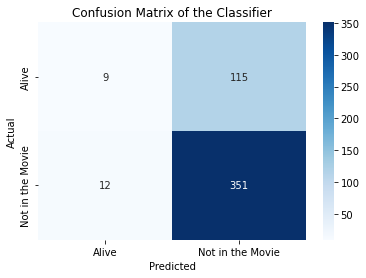

In [20]:
# calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = logreg_pred,
          labels = ['Alive', 'Not in the Movie']) 

In [21]:
# area under the roc curve (auc)
print(roc_auc_score(y_true  = y_test,
                    y_score = logreg_pred).round(decimals = 4))


# saving AUC score for future use
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = logreg_pred).round(decimals = 4)

0.5198


In [22]:
# zipping each feature name to its coefficient
logreg_model_values = zip(got[candidate_dict['logit_sig_2']].columns,
                          logreg_fit.coef_.ravel().round(decimals = 2))


# setting up a placeholder list to store model features
logreg_model_lst = [('intercept', logreg_fit.intercept_[0].round(decimals = 2))]


# printing out each feature-coefficient pair one by one
for val in logreg_model_values:
    logreg_model_lst.append(val)
    

# checking the results
for pair in logreg_model_lst:
    print(pair)

('intercept', 1.17)
('book1_A_Game_Of_Thrones', -0.58)
('popularity', 0.15)
('book5_A_Dance_with_Dragons', -2.08)


In [23]:
########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

In [24]:
# INSTANTIATING a classification tree object
full_tree = DecisionTreeClassifier()


# FITTING the training data
full_tree_fit = full_tree.fit(x_train, y_train)


# PREDICTING on new data
full_tree_pred = full_tree_fit.predict(x_test)


# SCORING the model
print('Full Tree Training ACCURACY:', full_tree_fit.score(x_train,
                                                     y_train).round(4))

print('Full Tree Testing ACCURACY :', full_tree_fit.score(x_test,
                                                     y_test).round(4))

print('Full Tree AUC Score:', roc_auc_score(y_true  = y_test,
                                            y_score = full_tree_pred).round(4))


# saving scoring data for future use
full_tree_train_score = full_tree_fit.score(x_train, y_train).round(4) # accuracy
full_tree_test_score  = full_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving AUC
full_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = full_tree_pred).round(4) # auc

Full Tree Training ACCURACY: 0.8396
Full Tree Testing ACCURACY : 0.7536
Full Tree AUC Score: 0.6383


In [25]:
# unpacking the confusion matrix
full_tree_tn, \
full_tree_fp, \
full_tree_fn, \
full_tree_tp = confusion_matrix(y_true = y_test, y_pred = full_tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {full_tree_tn}
False Positives: {full_tree_fp}
False Negatives: {full_tree_fn}
True Positives : {full_tree_tp}
""")


True Negatives : 50
False Positives: 74
False Negatives: 46
True Positives : 317



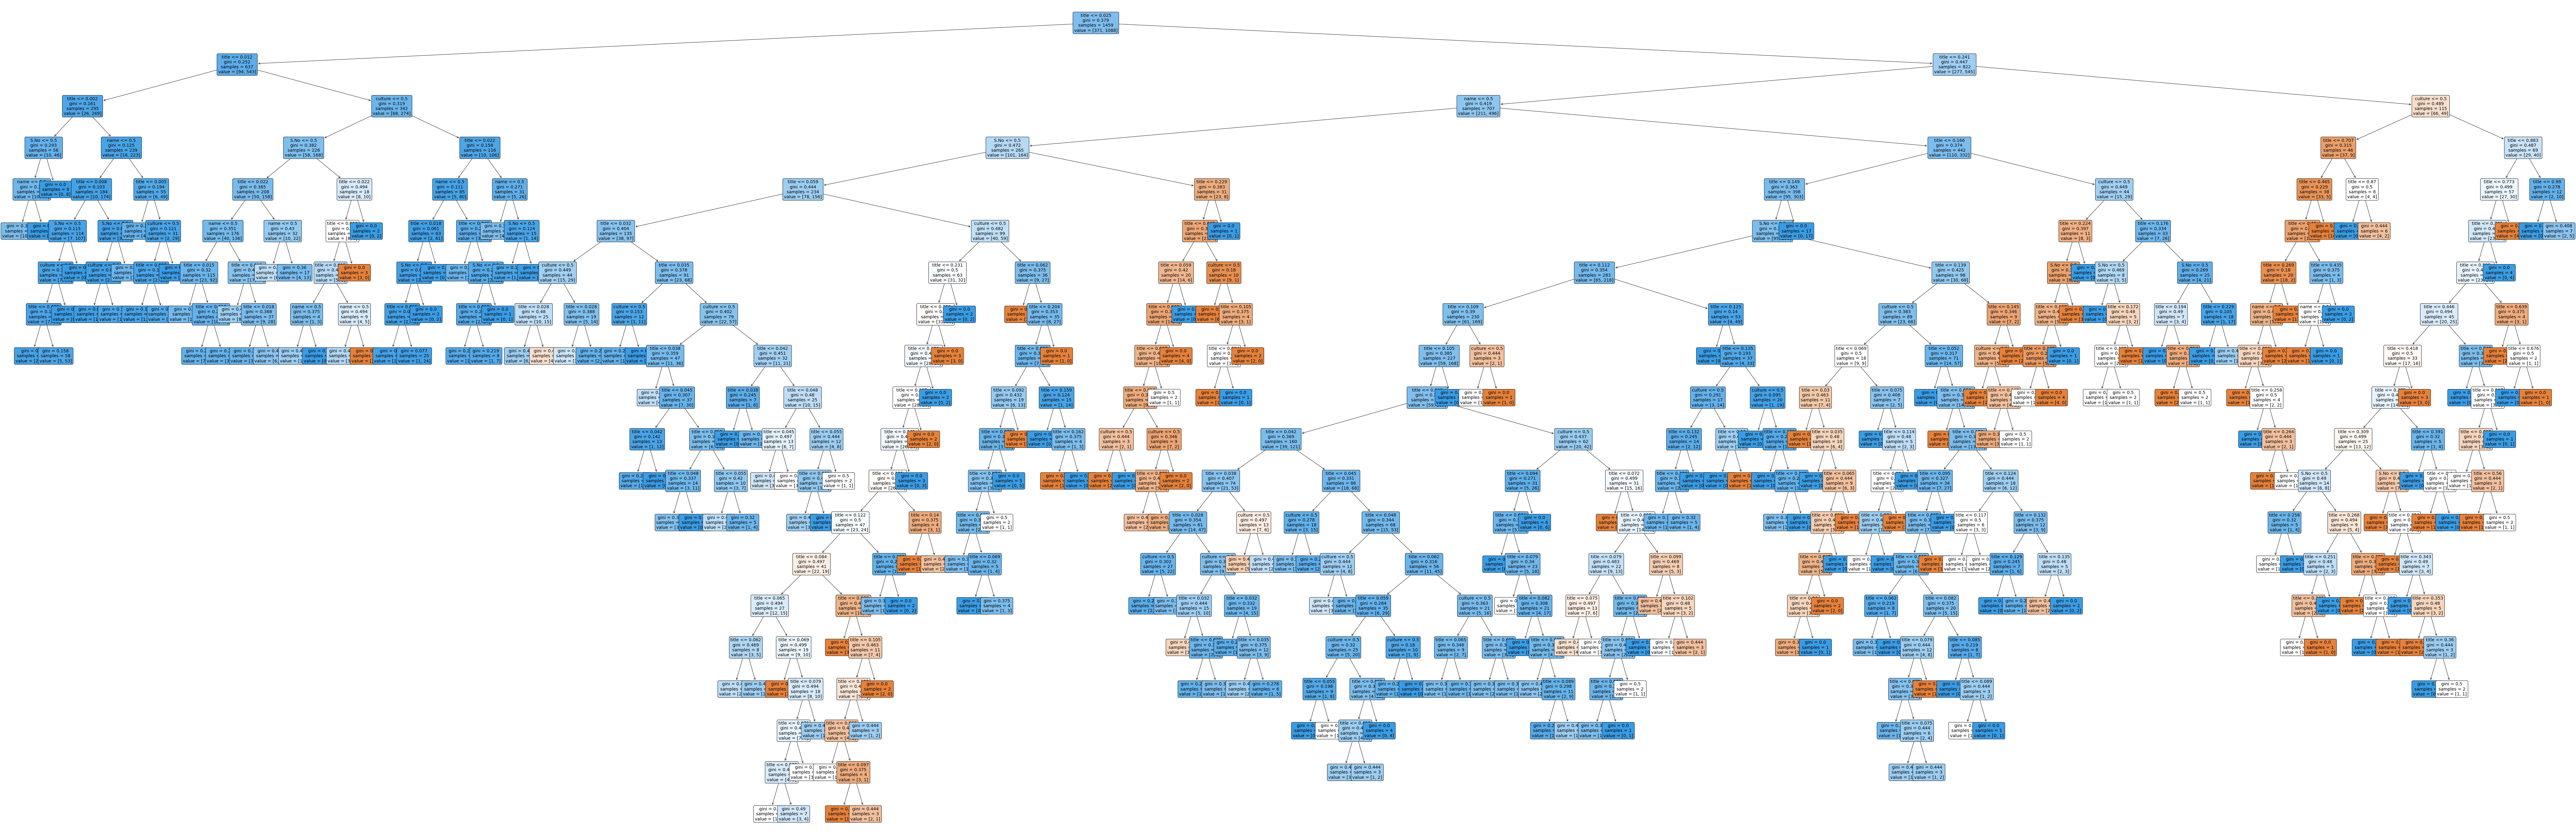

In [26]:
# setting figure size
plt.figure(figsize=(150,50))


# developing a plotted tree
plot_tree(decision_tree = full_tree_fit, 
          feature_names = got.columns,
          filled        = True, 
          rounded       = True, 
          fontsize      = 14)


# rendering the plot
plt.show()

In [27]:
# INSTANTIATING a classification tree object
pruned_tree = DecisionTreeClassifier(max_depth = 4,
                                     min_samples_leaf = 25,
                                     random_state = 219)


# FITTING the training data
pruned_tree_fit  = pruned_tree.fit(x_train, y_train)


# PREDICTING on new data
pruned_tree_pred = pruned_tree_fit.predict(x_test)


# SCORING the model
print('Training ACCURACY:', pruned_tree_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', pruned_tree_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = pruned_tree_pred).round(4))


# saving scoring data for future use
pruned_tree_train_score = pruned_tree_fit.score(x_train, y_train).round(4) # accuracy
pruned_tree_test_score  = pruned_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving auc score
pruned_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = pruned_tree_pred).round(4) # auc

Training ACCURACY: 0.7759
Testing  ACCURACY: 0.7639
AUC Score        : 0.5788


In [28]:
# unpacking the confusion matrix
pruned_tree_tn, \
pruned_tree_fp, \
pruned_tree_fn, \
pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = pruned_tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {pruned_tree_tn}
False Positives: {pruned_tree_fp}
False Negatives: {pruned_tree_fn}
True Positives : {pruned_tree_tp}
""")


True Negatives : 25
False Positives: 99
False Negatives: 16
True Positives : 347



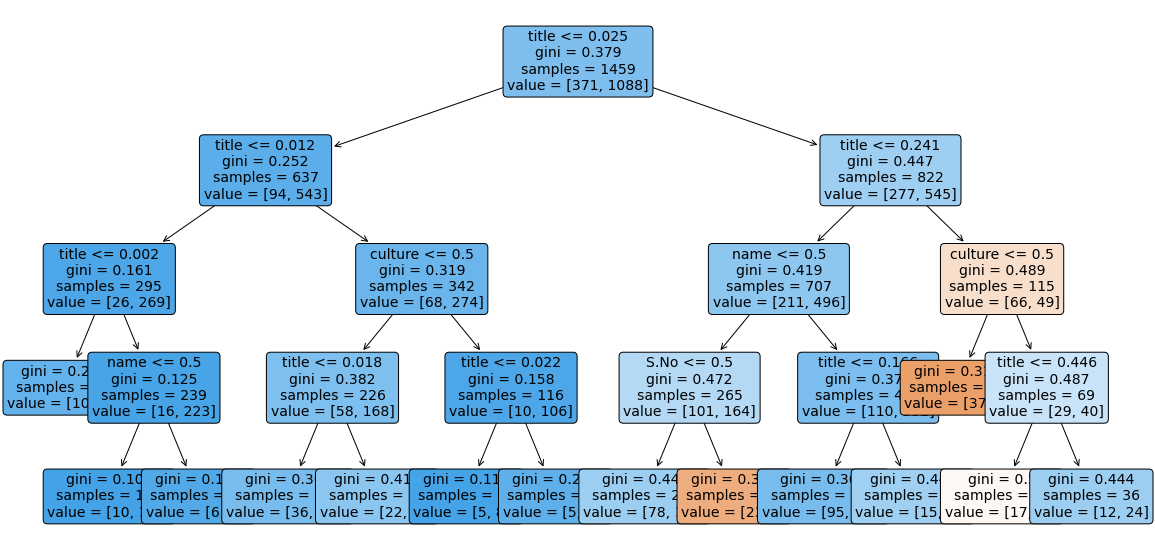

In [29]:
# setting figure size
plt.figure(figsize=(20, 10)) # adjusting to better fit the visual


# developing a plotted tree
plot_tree(decision_tree = pruned_tree_fit, # changing to pruned_tree_fit
          feature_names = got.columns,
          filled        = True, 
          rounded       = True, 
          fontsize      = 14)


# rendering the plot
plt.show()

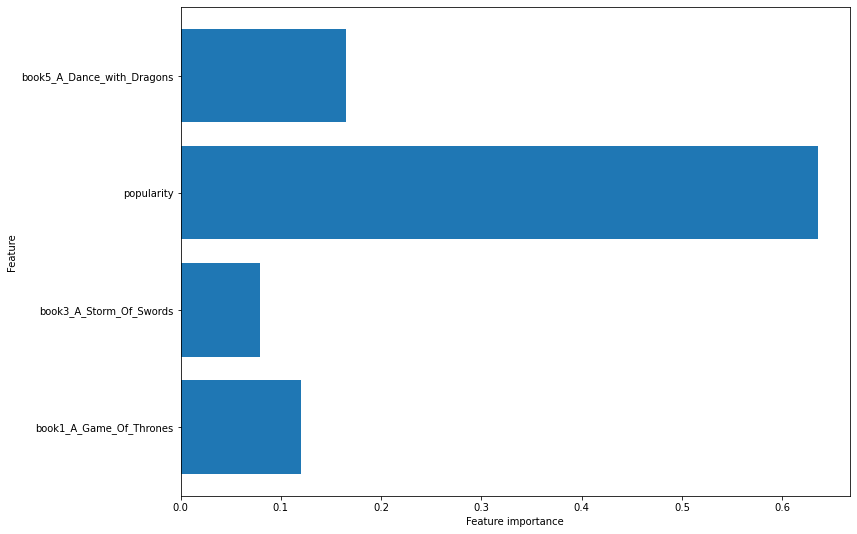

In [30]:
# plotting feature importance
plot_feature_importances(pruned_tree_fit,
                         train = x_train,
                         export = False)

In [31]:
# comparing results
print(f"""
Model         AUC Score      TN, FP, FN, TP
-----         ---------      --------------
Logistic      {logreg_auc_score}         {logreg_tn, logreg_fp, logreg_fn, logreg_tp}
Full Tree     {full_tree_auc_score}           {full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp}
Pruned Tree   {pruned_tree_auc_score}         {pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp}
""")


# creating a dictionary for model results
model_performance = {
    
    'Model Name'    : ['Logistic', 'Full Tree', 'Pruned Tree'],
           
    'AUC Score' : [logreg_auc_score, full_tree_auc_score, pruned_tree_auc_score],
    
    'Training Accuracy' : [logreg_train_score, full_tree_train_score,
                           pruned_tree_train_score],
           
    'Testing Accuracy'  : [logreg_test_score, full_tree_test_score,
                           pruned_tree_test_score],

    'Confusion Matrix'  : [(logreg_tn, logreg_fp, logreg_fn, logreg_tp),
                           (full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp),
                           (pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp)]}


# converting model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)


# sending model results to Excel
model_performance.to_excel('./__results/classification_model_performance.xlsx',
                           index = False)


Model         AUC Score      TN, FP, FN, TP
-----         ---------      --------------
Logistic      0.5198         (9, 115, 12, 351)
Full Tree     0.6383           (50, 74, 46, 317)
Pruned Tree   0.5788         (25, 99, 16, 347)



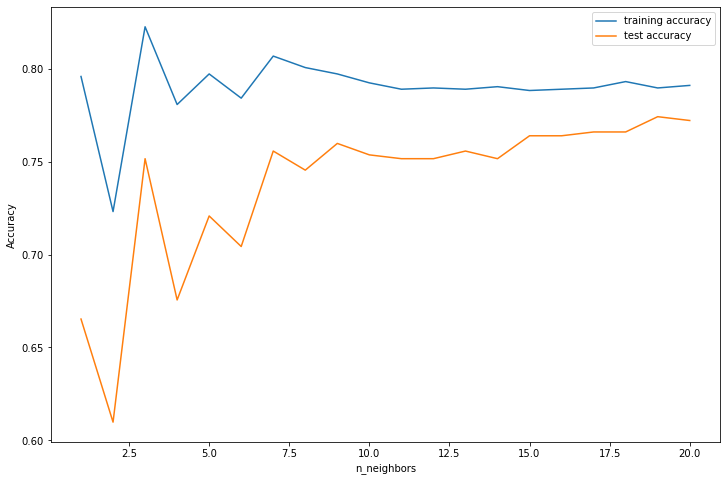

The optimal number of neighbors is: 19


In [32]:
# determining the optimal number of neighbors
opt_neighbors = optimal_neighbors(x_data        = got_data,
                                  y_data        = got_target,
                                  response_type = 'class')

In [33]:
# INSTANTIATING StandardScaler()
scaler = StandardScaler()


# FITTING the data
scaler.fit(got_data)


# TRANSFORMING the data
x_scaled     = scaler.transform(got_data)


# converting to a DataFrame
x_scaled_df  = pd.DataFrame(x_scaled) 


# train-test split with the scaled data
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            x_scaled_df,
            got_target,
            random_state = 219,
            test_size    = 0.25,
            stratify     = got_target)


# INSTANTIATING a KNN classification model with optimal neighbors
knn_opt = KNeighborsClassifier(n_neighbors = opt_neighbors)


# FITTING the training data
knn_fit = knn_opt.fit(x_train_scaled, y_train_scaled)


# PREDICTING based on the testing set
knn_pred = knn_fit.predict(x_test_scaled)


# SCORING the results
print('Training ACCURACY:', knn_fit.score(x_train_scaled, y_train_scaled).round(4))
print('Testing  ACCURACY:', knn_fit.score(x_test_scaled, y_test_scaled).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4))


# saving scoring data
knn_train_score = knn_fit.score(x_train_scaled, y_train_scaled).round(4)
knn_test_score  = knn_fit.score(x_test_scaled, y_test_scaled).round(4)


# saving AUC score
knn_auc_score   = roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4)

Training ACCURACY: 0.78
Testing  ACCURACY: 0.7988
AUC Score        : 0.6287


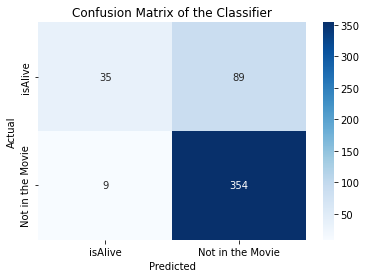

In [34]:
# calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = knn_pred,
          labels = ['isAlive', 'Not in the Movie'])

In [35]:
# unpacking the confusion matrix
knn_tree_tn, \
knn_tree_fp, \
knn_tree_fn, \
knn_tree_tp = confusion_matrix(y_true = y_test, y_pred = knn_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {pruned_tree_tn}
False Positives: {pruned_tree_fp}
False Negatives: {pruned_tree_fn}
True Positives : {pruned_tree_tp}
""")


True Negatives : 25
False Positives: 99
False Negatives: 16
True Positives : 347



In [36]:
# new packages
from sklearn.model_selection import RandomizedSearchCV     # hyperparameter tuning
from sklearn.metrics import make_scorer              # customizable scorer


########################################
# loading data and setting display options
########################################
# loading data
got = pd.read_excel('./__storage/GOT_character_predictions.xlsx')


# loading model performance
model_performance = pd.read_excel('./__results/classification_model_performance.xlsx')


# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)


########################################
# explanatory variable sets
########################################
candidate_dict = {

 # full model
 'logit_full'   : ['book1_A_Game_Of_Thrones', 'book3_A_Storm_Of_Swords',
                   'book5_A_Dance_with_Dragons', 'popularity', 'book5_A_Dance_with_Dragons', 
                   'book4_A_Feast_For_Crows','age' ],
 

 # significant variables only (set 1)
 'logit_sig'    : ['book1_A_Game_Of_Thrones' , 'book3_A_Storm_Of_Swords', 'popularity', 
                   'book5_A_Dance_with_Dragons',
                   ],
    
    
 # significant variables only (set 2)
 'logit_sig_2'  : ['book1_A_Game_Of_Thrones', 'popularity', 'book5_A_Dance_with_Dragons',
                   ]

}


########################################
# checking previous model performances
########################################
model_performance

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic,0.5198,0.7498,0.7392,"(9, 115, 12, 351)"
1,Full Tree,0.6383,0.8396,0.7536,"(50, 74, 46, 317)"
2,Pruned Tree,0.5788,0.7759,0.7639,"(25, 99, 16, 347)"


In [37]:
# train/test split with the logit_sig variables
got_data   =  got.loc[ : , candidate_dict['logit_sig_2']]
got_target =  got.loc[ : , 'isAlive']


# train/test split
x_train, x_test, y_train, y_test = train_test_split(
            got_data,
            got_target,
            random_state = 219,
            test_size    = 0.25,
            stratify     = got_target)

In [38]:
# INSTANTIATING a logistic regression model with default values
lr_default = LogisticRegression(solver = 'lbfgs',
                                C = 1.0,
                                warm_start = False,
                                random_state = 219)

In [39]:
# FITTING the training data
lr_default_fit = lr_default.fit(x_train, y_train)


# PREDICTING based on the testing set
lr_default_pred = lr_default_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', lr_default_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', lr_default_fit.score(x_test, y_test).round(4))


# SCORING with AUC
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = lr_default_pred).round(4))


# saving scoring data for future use
logreg_train_score = lr_default_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = lr_default_fit.score(x_test, y_test).round(4)   # accuracy


# saving AUC score
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = lr_default_pred).round(4)

Training ACCURACY: 0.7498
Testing  ACCURACY: 0.7372
AUC Score        : 0.5157


In [40]:
########################################
# RandomizedSearchCV
########################################

# declaring a hyperparameter space
C_range          = np.arange(0.1, 5.0, 0.1)
warm_start_range = [True, False]
solver_range     = ['newton-cg', 'sag', 'lbfgs']


# creating a hyperparameter grid
param_grid = {'C'          : C_range,
              'warm_start' : warm_start_range,
              'solver'     : solver_range}


# INSTANTIATING the model object without hyperparameters
lr_tuned = LogisticRegression(random_state = 219,
                              max_iter     = 1000) # increased for convergence


# GridSearchCV object
lr_tuned_cv = RandomizedSearchCV(estimator           = lr_tuned,   # the model object
                                 param_distributions = param_grid, # parameters to tune
                                 cv                  = 3,          # how many folds in cross-validation
                                 n_iter              = 250,        # number of combinations of hyperparameters to try
                                 random_state        = 219,        # starting point for random sequence
                                 scoring = make_scorer(
                                           roc_auc_score,
                                           needs_threshold = False)) # scoring criteria (AUC)


# FITTING to the FULL DATASET (due to cross-validation)
lr_tuned_cv.fit(got_data, got_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", lr_tuned_cv.best_params_)
print("Tuned CV AUC      :", lr_tuned_cv.best_score_.round(4))

Tuned Parameters  : {'warm_start': True, 'solver': 'lbfgs', 'C': 2.8000000000000003}
Tuned CV AUC      : 0.5263


In [41]:
# checking the results of RandomizedSearch CV
lr_tuned_cv.cv_results_

{'mean_fit_time': array([0.03656069, 0.01110983, 0.00731214, 0.00689189, 0.00732501,
        0.00904679, 0.0065558 , 0.00590714, 0.00773462, 0.00725428,
        0.00616177, 0.00703041, 0.00531586, 0.00730817, 0.00948517,
        0.004644  , 0.00531514, 0.00733495, 0.00449959, 0.00720827,
        0.00498303, 0.00531507, 0.00782458, 0.00499988, 0.00713388,
        0.00500552, 0.00499153, 0.00567651, 0.0056843 , 0.0081892 ,
        0.00504756, 0.00590706, 0.00999355, 0.00688616, 0.00631213,
        0.00906642, 0.00854731, 0.00818022, 0.00559092, 0.00611941,
        0.0084796 , 0.00531602, 0.00383981, 0.00668772, 0.00887291,
        0.0080262 , 0.00667961, 0.00605567, 0.00662128, 0.00630824,
        0.00643635, 0.00581654, 0.0059797 , 0.00702294, 0.00815455,
        0.00752242, 0.00682036, 0.00693727, 0.00664306, 0.00810122,
        0.00850066, 0.00550143, 0.00556763, 0.00627573, 0.00637762,
        0.00859388, 0.00642967, 0.00514619, 0.00513482, 0.00464988,
        0.00670671, 0.00786169,

In [42]:
# checking the best estimator for the model
lr_tuned_cv.best_estimator_

LogisticRegression(C=2.8000000000000003, max_iter=1000, random_state=219,
                   warm_start=True)

In [43]:
# building a model based on hyperparameter tuning results

# INSTANTIATING a logistic regression model with tuned values
lr_tuned = LogisticRegression(C            = 2.4000000000000004,
                              warm_start   = False,
                              solver       = 'lbfgs',
                              max_iter     = 1000,
                              random_state = 219)


# FITTING the model to the full dataset
lr_tuned.fit(got_data, got_target) # this is ok because already tuned


# PREDICTING based on the testing set
lr_tuned_pred = lr_tuned.predict(x_test)


# SCORING the results
print('LR Tuned Training ACCURACY:', lr_tuned.score(x_train, y_train).round(4))
print('LR Tuned Testing  ACCURACY:', lr_tuned.score(x_test, y_test).round(4))
print('LR Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = lr_tuned_pred).round(4))


# saving scoring data for future use
lr_tuned_train_score = lr_tuned.score(x_train, y_train).round(4) # accuracy
lr_tuned_test_score  = lr_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
lr_tuned_auc         = roc_auc_score(y_true  = y_test,
                                     y_score = lr_tuned_pred).round(4) # auc

LR Tuned Training ACCURACY: 0.7491
LR Tuned Testing  ACCURACY: 0.7351
LR Tuned AUC Score        : 0.5117


In [44]:
# unpacking the confusion matrix
lr_tuned_tn, \
lr_tuned_fp, \
lr_tuned_fn, \
lr_tuned_tp = confusion_matrix(y_true = y_test, y_pred = lr_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {lr_tuned_tn}
False Positives: {lr_tuned_fp}
False Negatives: {lr_tuned_fn}
True Positives : {lr_tuned_tp}
""")


True Negatives : 7
False Positives: 117
False Negatives: 12
True Positives : 351



In [45]:
# loading model performance
model_performance = pd.read_excel('./__results/classification_model_performance.xlsx')


# declaring model performance objects
lr_train_acc = lr_tuned.score(x_train, y_train).round(4)
lr_test_acc  = lr_tuned.score(x_test, y_test).round(4)
lr_auc       = roc_auc_score(y_true  = y_test,
                             y_score = lr_tuned_pred).round(4)


# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'        : 'Tuned LR',
                           'Training Accuracy' : lr_train_acc,
                           'Testing Accuracy'  : lr_test_acc,
                           'AUC Score'         : lr_auc,
                           'Confusion Matrix'  : (lr_tuned_tn,
                                                  lr_tuned_fp,
                                                  lr_tuned_fn,
                                                  lr_tuned_tp)},
                           ignore_index = True)


# checking the results
model_performance

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic,0.5198,0.7498,0.7392,"(9, 115, 12, 351)"
1,Full Tree,0.6383,0.8396,0.7536,"(50, 74, 46, 317)"
2,Pruned Tree,0.5788,0.7759,0.7639,"(25, 99, 16, 347)"
3,Tuned LR,0.5117,0.7491,0.7351,"(7, 117, 12, 351)"


In [46]:
# declaring a hyperparameter space
criterion_range = ['gini', 'entropy']
splitter_range  = ['best', 'random']
depth_range     = np.arange(1, 25, 1)
leaf_range      = np.arange(1, 100, 1)


# creating a hyperparameter grid
param_grid = {'criterion'        : criterion_range,
              'splitter'         : splitter_range,
              'max_depth'        : depth_range,
              'min_samples_leaf' : leaf_range}


# INSTANTIATING the model object without hyperparameters
tuned_tree = DecisionTreeClassifier(random_state = 219)


# RandomizedSearchCV object
tuned_tree_cv = RandomizedSearchCV(estimator             = tuned_tree,
                                   param_distributions   = param_grid,
                                   cv                    = 3,
                                   n_iter                = 1000,
                                   random_state          = 219,
                                   scoring = make_scorer(roc_auc_score,
                                             needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
tuned_tree_cv.fit(got_data, got_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", tuned_tree_cv.best_params_)
print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))

Tuned Parameters  : {'splitter': 'random', 'min_samples_leaf': 2, 'max_depth': 12, 'criterion': 'entropy'}
Tuned Training AUC: 0.6172


In [47]:
# building a model based on hyperparameter tuning results

# INSTANTIATING a logistic regression model with tuned values
tree_tuned = DecisionTreeClassifier(splitter         = 'random',
                                    min_samples_leaf = 3,
                                    max_depth        = 4,
                                    criterion        = 'gini',
                                    random_state     = 219)


# FITTING to the FULL DATASET (due to cross-validation)
tree_tuned_fit = tree_tuned.fit(got_data, got_target)


# PREDICTING based on the testing set
tree_tuned_pred = tree_tuned.predict(x_test)


# SCORING the results
print('Training ACCURACY:', tree_tuned.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', tree_tuned.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_tuned_pred).round(4))


# saving scoring data for future use
tree_tuned_train_score = tree_tuned.score(x_train, y_train).round(4) # accuracy
tree_tuned_test_score  = tree_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
tree_tuned_auc         = roc_auc_score(y_true  = y_test,
                                       y_score = tree_tuned_pred).round(4) # auc

Training ACCURACY: 0.7724
Testing  ACCURACY: 0.7988
AUC Score        : 0.6314


In [48]:
# unpacking the confusion matrix
tuned_tree_tn, \
tuned_tree_fp, \
tuned_tree_fn, \
tuned_tree_tp = confusion_matrix(y_true = y_test, y_pred = tree_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_tree_tn}
False Positives: {tuned_tree_fp}
False Negatives: {tuned_tree_fn}
True Positives : {tuned_tree_tp}
""")


True Negatives : 36
False Positives: 88
False Negatives: 10
True Positives : 353



In [49]:
# declaring model performance objects
tree_train_acc = tree_tuned.score(x_train, y_train).round(4)
tree_test_acc  = tree_tuned.score(x_test, y_test).round(4)
tree_auc       = roc_auc_score(y_true  = y_test,
                              y_score = tree_tuned_pred).round(4)


# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'        : 'Tuned Tree',
                           'Training Accuracy' : tree_train_acc,
                           'Testing Accuracy'  : tree_test_acc,
                           'AUC Score'         : tree_auc,
                           'Confusion Matrix'  : (tuned_tree_tn,
                                                  tuned_tree_fp,
                                                  tuned_tree_fn,
                                                  tuned_tree_tp)},
                           ignore_index = True)


# checking the results
model_performance

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic,0.5198,0.7498,0.7392,"(9, 115, 12, 351)"
1,Full Tree,0.6383,0.8396,0.7536,"(50, 74, 46, 317)"
2,Pruned Tree,0.5788,0.7759,0.7639,"(25, 99, 16, 347)"
3,Tuned LR,0.5117,0.7491,0.7351,"(7, 117, 12, 351)"
4,Tuned Tree,0.6314,0.7724,0.7988,"(36, 88, 10, 353)"


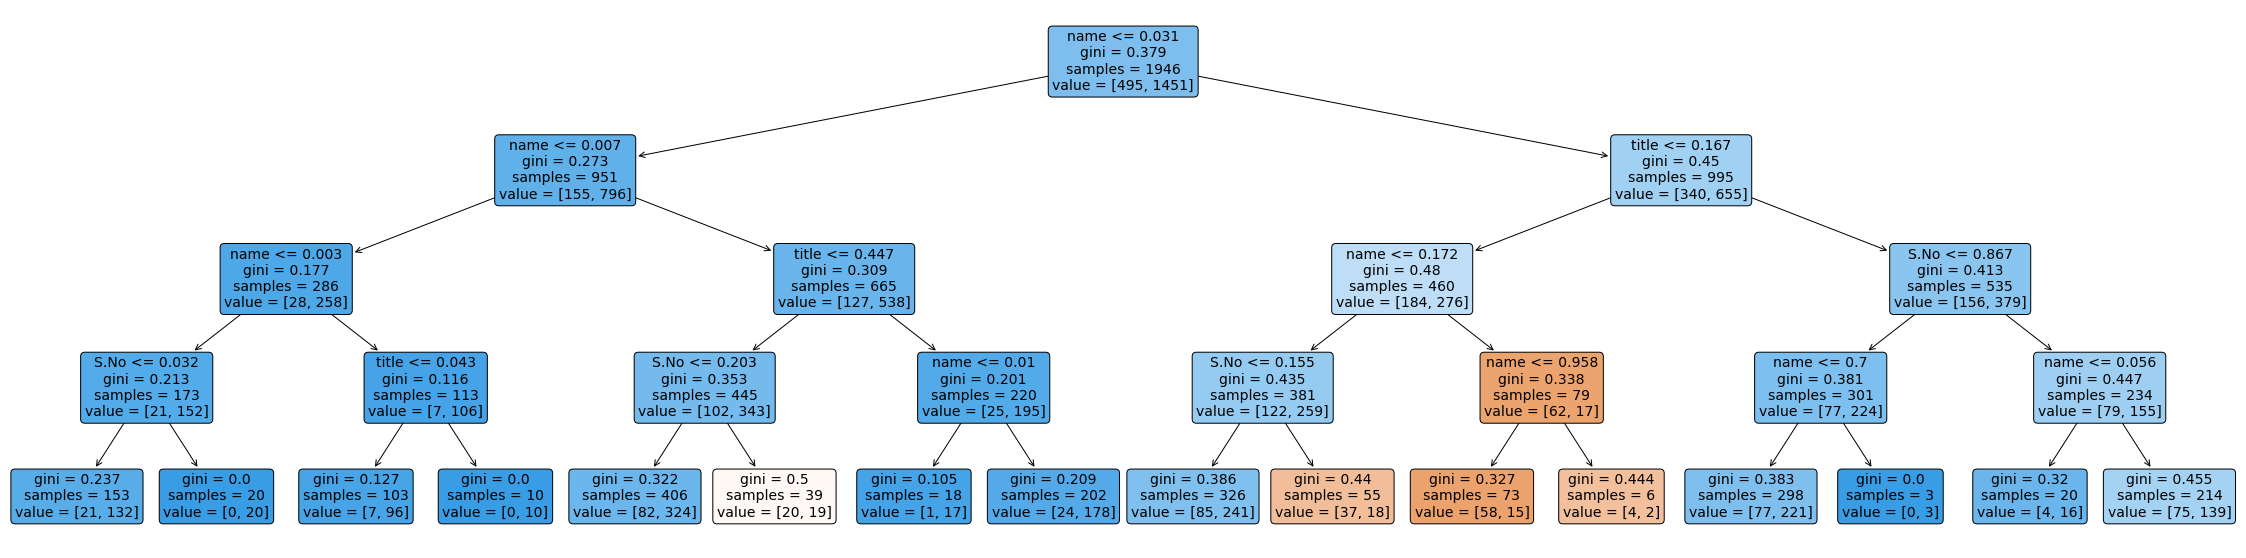

In [50]:
# setting figure size
plt.figure(figsize=(40, 10))


# developing a plotted tree
plot_tree(decision_tree = tree_tuned_fit, 
          feature_names = got.columns,
          filled        = True, 
          rounded       = True, 
          fontsize      = 14)


# rendering the plot
plt.show()

In [51]:
# saving the DataFrame to Excel
model_performance.to_excel('./__results/classification_model_performance.xlsx',
                           index = False)

In [56]:
########################################
# importing packages
########################################
# new tools
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm


########################################
# loading data and setting display options
########################################
# loading data
got = pd.read_excel('./__storage/GOT_character_predictions.xlsx')


# loading model performance
model_performance = pd.read_excel('./__results/classification_model_performance.xlsx')


# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)


########################################
# explanatory variable sets
########################################
candidate_dict = {

 # full model
 'logit_full'   : ['book1_A_Game_Of_Thrones', 'book3_A_Storm_Of_Swords',
                   'book5_A_Dance_with_Dragons', 'popularity', 'book5_A_Dance_with_Dragons', 
                   'book4_A_Feast_For_Crows','age' ],
 

 # significant variables only (set 1)
 'logit_sig'    : ['book1_A_Game_Of_Thrones' , 'book3_A_Storm_Of_Swords', 'popularity', 
                   'book5_A_Dance_with_Dragons',
                   ],
    
    
 # significant variables only (set 2)
 'logit_sig_2'  : ['book1_A_Game_Of_Thrones', 'popularity', 'book5_A_Dance_with_Dragons',
                   ]

}


########################################
# checking previous model performances
########################################
model_performance

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic,0.5198,0.7498,0.7392,"(9, 115, 12, 351)"
1,Full Tree,0.6383,0.8396,0.7536,"(50, 74, 46, 317)"
2,Pruned Tree,0.5788,0.7759,0.7639,"(25, 99, 16, 347)"
3,Tuned LR,0.5117,0.7491,0.7351,"(7, 117, 12, 351)"
4,Tuned Tree,0.6314,0.7724,0.7988,"(36, 88, 10, 353)"


In [57]:
########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('./analysis_images/Feature_Importance.png')

In [58]:
# train/test split with the logit_sig variables
got_data   =  got.loc[ : , candidate_dict['logit_full']]
got_target =  got.loc[ : , 'isAlive']


# train/test split
x_train, x_test, y_train, y_test = train_test_split(
            got_data,
            got_target,
            random_state = 219,
            test_size    = 0.25,
            stratify     = got_target)

In [61]:
# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'gini',
                                    max_depth        = None,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 219)

In [62]:
# FITTING the training data
rf_default_fit = rf_default.fit(x_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', rf_default_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', rf_default_fit.score(x_test, y_test).round(4))


# saving AUC score
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').